In [1]:
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress
import pandas as pd
import pickle
from os import listdir
from os.path import isfile, join
from ll_xy import lonlat_to_xy
from netCDF4 import Dataset
import mask
from field_importer import get_field
from scipy.spatial import KDTree
import itertools

In [2]:
sit_dict = pickle.load(open('../data/sits.p','rb'))

In [3]:
locations = {'a':(75,-152),
             'b':(78,-150),
             'd':(74,-140),
            }
loc_xy = {}
for loc in locations.keys():
    
    x,y = lonlat_to_xy(np.array(locations[loc][1]),
                       np.array(locations[loc][0]),
                       hemisphere='n')
    loc_xy[loc] = (x,y)

loc_xy

lons, lats = mask.get('lon'), mask.get('lat')
ex, ey = lonlat_to_xy(lons,lats,hemisphere='n')

tree = KDTree(list(zip(ex.ravel(),ey.ravel())))

inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (361,361))
    
    inds[buoy] = ind2d

In [4]:
yearlist = np.arange(2011,2021)
monthlist = ["10","11","12","01","02","03","04"]

colors = {'a':'#a6cee3',
          'b':'#1f78b4',
          'c':'orange',
          'd':'#33a02c'}

In [5]:
# buoy_dfs = {}

# for buoy in ['a','b','d']:

#     dfs = []
#     for year in np.arange(2005,2021):
        
#         try:
#             with h5py.File(f'../data/ULS/ULS/uls{str(year-2000).zfill(2)}{buoy}_dailyn.mat') as mat:

#                 x = np.array(mat['IDS'])[1]
#                 dt = np.array(mat['yday'])[0]

#                 j1 = datetime.date(year,1,1)

#                 dates = [j1+datetime.timedelta(days=int(d)) for d in dt]
#                 months = [d.month for d in dates]
#                 years = [d.year for d in dates]

#                 df = pd.DataFrame({'draft':x,
#                                'date':dates,
#                                'year':years,
#                                'month':months})

#                 dfs.append(df)
            
#         except:
#             pass
        
#     df = pd.concat(dfs)
    
#     buoy_dfs[buoy] = df
    

In [6]:
d = Dataset(f'/home/robbie/Dropbox/ULS_vs_climatology/data/ULS/ULS/ULS_SIT_{buoy.upper()}.nc')
d

sit = np.array(d['Sea Ice Thickness'])
days = np.array(d['Day'])
dt0 = datetime.date(2010,1,1)
dates = [dt0 + datetime.timedelta(days=int(x)) for x in days]

In [7]:
buoy_dfs = {}

for buoy in ['a','b','d']:
    
    d = Dataset(f'/home/robbie/Dropbox/ULS_vs_climatology/data/ULS/ULS/ULS_SIT_{buoy.upper()}.nc')
    sit = np.array(d['Sea Ice Thickness'])
    days = np.array(d['Day'])
    dt0 = datetime.date(2010,1,1)
    dates = np.asarray([dt0 + datetime.timedelta(days=int(x)) for x in days])
    months = np.asarray([x.month for x in dates])
    years = np.asarray([x.year for x in dates])
    
    
    dfs = []
    
    for year in np.arange(2005,2021):
        
        df = pd.DataFrame({'SIT':sit[years==year],
                           'year':years[years==year],
                          'month':months[years==year],
                          'date':dates[years==year]})
        
        dfs.append(df)
        
        
    df = pd.concat(dfs)
    
    buoy_dfs[buoy] = df
    

In [8]:
master_df = []


for buoy, df in buoy_dfs.items():

    years_active = set(df['year'])
    
    list_of_dicts = []    

    for year in np.arange(2011,2021):

        df_yr = df[df['year']==year]

        for month in monthlist:

            df_yr_mo = df_yr[df_yr['month']==int(month)]

            list_of_dicts.append({'year':year,'month':month,'SIT':np.nanmean(df_yr_mo['SIT'])})

    df_mo = pd.DataFrame(list_of_dicts).dropna()
    

    climatology = []
    SITS = []
    
    for month, year in zip(df_mo['month'],df_mo['year']):
        
        climatology.append( np.nanmean( df_mo[df_mo['month']==month]['SIT'] ) )
        


    df_mo['Climatology'] = climatology

    
    df_mo['buoy'] = buoy
    
    master_df.append(df_mo)

master_df = pd.concat(master_df)

# Now get the indices of the buoys in each SIT product

In [9]:
radii = [50_000,100_000,250_000,500_000, 1_000_000]

In [10]:
# AWI

d = Dataset('/home/robbie/Dropbox/SM_Thickness_Thesis/data/AWI_CS2/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201202-fv2p3.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

awi_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (432,432))
    
    radius_inds = {}
    
    for radius in radii:
        inds = tree.query_ball_point([x,y],r=radius)
        radius_inds[radius] = [np.unravel_index(ind, (432,432)) for ind in inds]
        
    awi_e2_inds[buoy] = {'0':[ind2d]}
    
    for r in radii:    awi_e2_inds[buoy][str(r)[:-3]] = radius_inds[r]

In [11]:
d = Dataset('../data/NSIDC/NSIDC/RDEFT4_20101114.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

nsidc_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (448,304))

    radius_inds = {}
    
    for radius in radii:
        inds = tree.query_ball_point([x,y],r=radius)
        radius_inds[radius] = [np.unravel_index(ind, (448,304)) for ind in inds]
        

    nsidc_e2_inds[buoy] = {'0':[ind2d]}
    
    for r in radii: nsidc_e2_inds[buoy][str(r)[:-3]] = radius_inds[r]
    
#     nsidc_e2_inds[buoy] = ind2d

In [12]:
d = Dataset('../data/W99/W99_361.nc')
e2_lon = np.array(d['lon'])
e2_lat = np.array(d['lat'])

e2_x, e2_y = lonlat_to_xy(e2_lon,e2_lat,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

w99_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (361,361))
    
    radius_inds = {}
    
    for radius in radii:
        inds = tree.query_ball_point([x,y],r=radius)
        radius_inds[radius] = [np.unravel_index(ind, (361,361)) for ind in inds]
        
    w99_e2_inds[buoy] = {'0':[ind2d]}
    
    for r in radii: w99_e2_inds[buoy][str(r)[:-3]] = radius_inds[r]
    
#     w99_e2_inds[buoy] = ind2d

In [13]:
df = pd.read_csv('../data/cpom/CPOM_CS2/201103.txt',sep = ' ')
cpom_lat = np.array(df.iloc[:,0])
cpom_lon = np.array(df.iloc[:,1])

cpom_longrid = np.reshape(cpom_lon, (1335, 1335))
cpom_latgrid = np.reshape(cpom_lat, (1335, 1335))

e2_x, e2_y = lonlat_to_xy(cpom_longrid,cpom_latgrid,hemisphere='n')

tree = KDTree(list(zip(e2_x.ravel(),e2_y.ravel())))

cpom_e2_inds = {}
for buoy, (x,y) in loc_xy.items():

    dist, ind = tree.query([x,y])

    ind2d = np.unravel_index(ind, (1335,1335))
    
    radius_inds = {}
    
    for radius in radii:
        inds = tree.query_ball_point([x,y],r=radius)
        radius_inds[radius] = [np.unravel_index(ind, (1335,1335)) for ind in inds]
        

    cpom_e2_inds[buoy] = {'0':[ind2d]}
    
    for r in radii: cpom_e2_inds[buoy][str(r)[:-3]] = radius_inds[r]
    
#     cpom_e2_inds[buoy] = ind2d

In [14]:
buoy_inds = {'cpom':cpom_e2_inds,
            'awi':awi_e2_inds,
            'nsidc':nsidc_e2_inds,
            'w99':w99_e2_inds}

In [15]:
master_df

,year,month,SIT,Climatology,buoy
0,2011,10,0.285705,0.263871,a
1,2011,11,0.595582,0.579560,a
2,2011,12,0.968010,0.884318,a
3,2011,01,1.149679,1.147697,a
4,2011,02,1.385042,1.411574,a
...,...,...,...,...,...
65,2020,12,0.807308,1.057245,d
66,2020,01,1.154570,1.303955,d
67,2020,02,1.406142,1.524532,d
68,2020,03,1.612743,1.704787,d


In [16]:
for r in [0]+radii:

    buoy_sits = {s:[] for s in buoy_inds.keys()}

    for month, year, buoy in zip(master_df['month'],master_df['year'],master_df['buoy']):

        for product in buoy_sits.keys():

            sit = sit_dict[product][year][month]
            
            buoy_inds_rad = buoy_inds[product][buoy][str(int(r/1000))]

            sit_inds = [sit[buoy_ind] for buoy_ind in buoy_inds_rad]
            

            buoy_sits[product].append(np.nanmean(sit_inds))


    for product in buoy_sits.keys():
        master_df[f'{product.upper()}_SIT_{r}'] = buoy_sits[product]

master_df

/tmp/ipykernel_19001/400116985.py:16: RuntimeWarning: Mean of empty slice
  buoy_sits[product].append(np.nanmean(sit_inds))
/tmp/ipykernel_19001/400116985.py:16: RuntimeWarning: Mean of empty slice
  buoy_sits[product].append(np.nanmean(sit_inds))
/tmp/ipykernel_19001/400116985.py:16: RuntimeWarning: Mean of empty slice
  buoy_sits[product].append(np.nanmean(sit_inds))


,year,month,SIT,Climatology,buoy,CPOM_SIT_0,AWI_SIT_0,NSIDC_SIT_0,W99_SIT_0,CPOM_SIT_50000,...,NSIDC_SIT_250000,W99_SIT_250000,CPOM_SIT_500000,AWI_SIT_500000,NSIDC_SIT_500000,W99_SIT_500000,CPOM_SIT_1000000,AWI_SIT_1000000,NSIDC_SIT_1000000,W99_SIT_1000000
0,2011,10,0.285705,0.263871,a,0.0000,NaN,1.110192,0.589068,0.179843,...,1.105496,0.587701,0.383789,0.653866,1.136217,0.580389,0.396044,0.931562,1.321869,0.617688
1,2011,11,0.595582,0.579560,a,0.0000,0.740336,1.333848,0.751418,0.873491,...,1.308873,0.751637,0.872235,0.743969,1.258178,0.745058,0.732456,0.985258,1.381801,0.800412
2,2011,12,0.968010,0.884318,a,1.3836,0.913696,1.228488,0.832887,1.267054,...,1.143556,0.835837,1.084327,0.913279,1.241195,0.830994,0.940501,1.099811,1.441611,0.907070
3,2011,01,1.149679,1.147697,a,1.1307,0.876177,1.429142,1.033542,1.011061,...,1.320170,1.036492,1.204309,1.090855,1.466349,1.035380,1.139497,1.373574,1.675770,1.096157
4,2011,02,1.385042,1.411574,a,1.2093,1.193916,1.590185,1.410290,1.385804,...,1.577663,1.409517,1.488180,1.452143,1.643302,1.404578,1.360896,1.710461,1.860487,1.385183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2020,12,0.807308,1.057245,d,1.3878,0.784678,1.305944,0.849238,1.217407,...,1.313251,0.839678,1.407625,1.182324,1.449969,0.835169,0.963327,1.398570,1.640976,0.971910
66,2020,01,1.154570,1.303955,d,1.1374,1.332576,1.442706,1.062369,1.286345,...,1.474264,1.056970,1.460233,1.378948,1.724838,1.056192,0.996651,1.521634,1.855522,1.156857
67,2020,02,1.406142,1.524532,d,1.0642,1.425656,1.090390,1.430937,1.108211,...,1.592082,1.428973,1.493334,1.499515,1.786254,1.423984,1.080990,1.680256,1.929983,1.412977
68,2020,03,1.612743,1.704787,d,1.7035,1.818803,1.608235,1.594553,1.706947,...,1.770838,1.595122,1.921796,1.978044,1.972283,1.590889,1.311828,2.079365,2.209888,1.528121


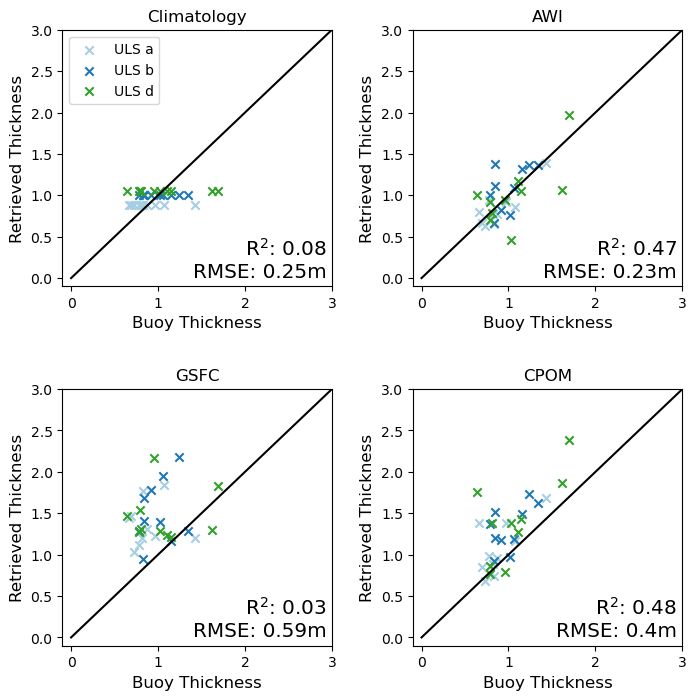

In [17]:
m = '12'

fig, axs = plt.subplots(2,2,figsize=(8,8))

r = '0'

for var,label,ax in zip(['Climatology',f'AWI_SIT_{r}',f'NSIDC_SIT_{r}',f'CPOM_SIT_{r}'],
                        ['Climatology','AWI','GSFC','CPOM'],
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        df = df[df['month']==m]
        
        ax.scatter(df['SIT'],df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['SIT',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    df = df[df['month']==m]
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['SIT'])))
    
    lr = linregress(df['SIT'],df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

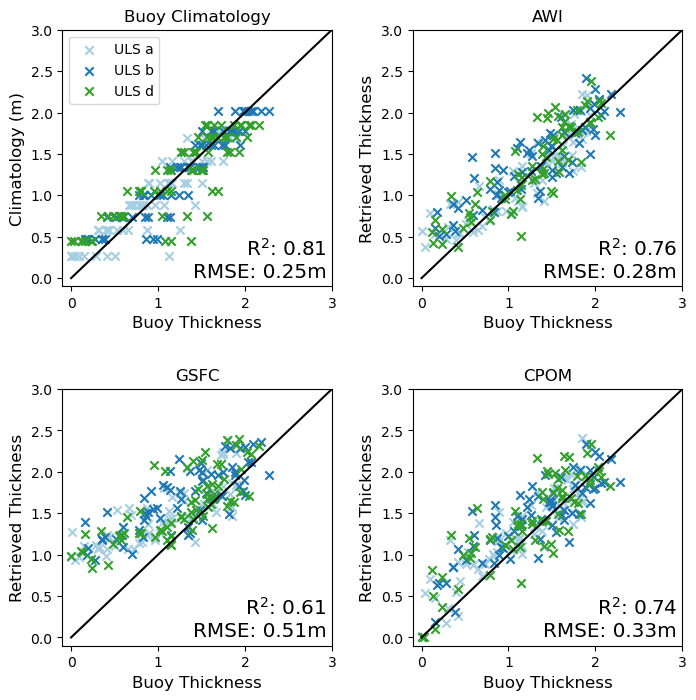

In [18]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

r = radii[0]

for var,label,ax in zip([f'Climatology',f'AWI_SIT_{r}',f'NSIDC_SIT_{r}',f'CPOM_SIT_{r}'],
                        ['Buoy Climatology','AWI','GSFC','CPOM'],
                        # Climatology, W99_SIT
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        ax.scatter(df['SIT'],df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['SIT',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['SIT'])))
    
    lr = linregress(df['SIT'],df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')

axs.reshape(-1)[0].set_ylabel('Climatology (m)',fontsize='large')

fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

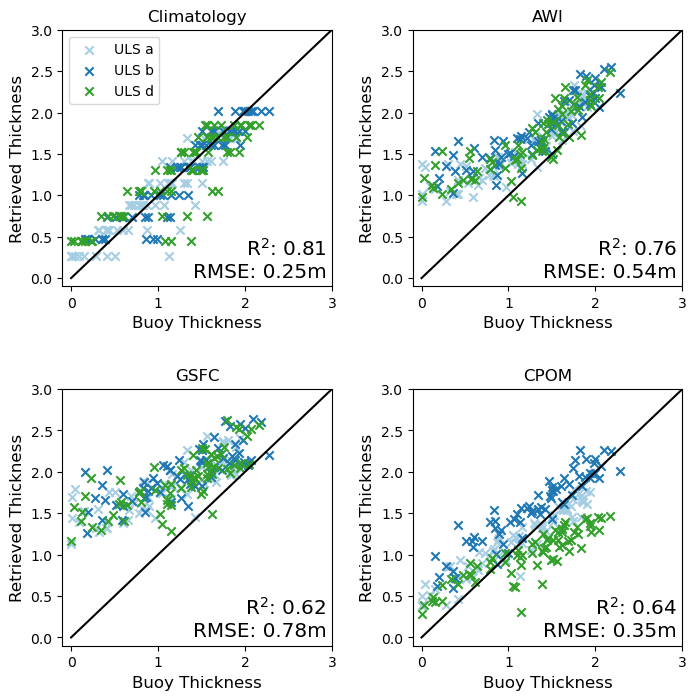

In [19]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

r = radii[-1]

for var,label,ax in zip([f'Climatology',f'AWI_SIT_{r}',f'NSIDC_SIT_{r}',f'CPOM_SIT_{r}'],
                        ['Climatology','AWI','GSFC','CPOM'],
                        # Climatology, W99_SIT
                        axs.reshape(-1)):

    for buoy in ['a','b','d']:
        df = master_df[master_df['buoy']==buoy]
        
        ax.scatter(df['SIT'],df[var],color=colors[buoy],label=f'ULS {buoy}',marker='x')
        
    ax.set_ylim(-0.1,3)
    ax.set_xlim(-0.1,3)
    ax.set_xlabel('Buoy Thickness',fontsize='large')
    ax.set_ylabel('Retrieved Thickness',fontsize='large')
    ax.plot([0,3],[0,3],color='k')
    
    
    df = master_df[['SIT',var,'month']].copy()
    
    df.dropna(inplace=True)
    
    rmse = np.sqrt(np.nanmean(np.square(df[var]-df['SIT'])))
    
    lr = linregress(df['SIT'],df[var])
    r = lr[2]
    
    r2 = np.round(r**2,decimals=2)
    rmse_str = np.round(rmse,decimals=2)
    
    ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                xycoords='axes fraction',va='bottom',ha='right',fontsize='x-large')
    ax.set_title(label,fontsize='large')

axs.reshape(-1)[0].legend(loc='upper left',fontsize='medium')
fig.subplots_adjust(hspace=0.4,wspace=0.3)
plt.show()

In [20]:
for r in [0] + radii:
    
    print(f'Radius: {r}')

    products = ['AWI_SIT','NSIDC_SIT','CPOM_SIT']

    pclims = []

    for month, buoy in itertools.product(monthlist,['a','b','d']):

        cd = master_df[(master_df['month']==month) & (master_df['buoy']==buoy)]

        for product in products:

            nm = np.nanmean(cd[f'{product}_{r}'])


            pclims.append( {'product':product,'month':month,'buoy':buoy,'SIT':nm} )

    df = pd.DataFrame(pclims)

    pclims = {p:[] for p in products}

    for month, buoy in zip(master_df['month'],master_df['buoy']):

        for product in products:

            val  = float(df[(df['product']==product)&(df['buoy']==buoy)&(df['month']==month)]['SIT'])

            pclims[product].append(val)

    for p in products:

        master_df[p+f'_{r}'+'_c'] = pclims[p]

Radius: 0
Radius: 50000
Radius: 100000
Radius: 250000
Radius: 500000
Radius: 1000000


In [25]:
import string

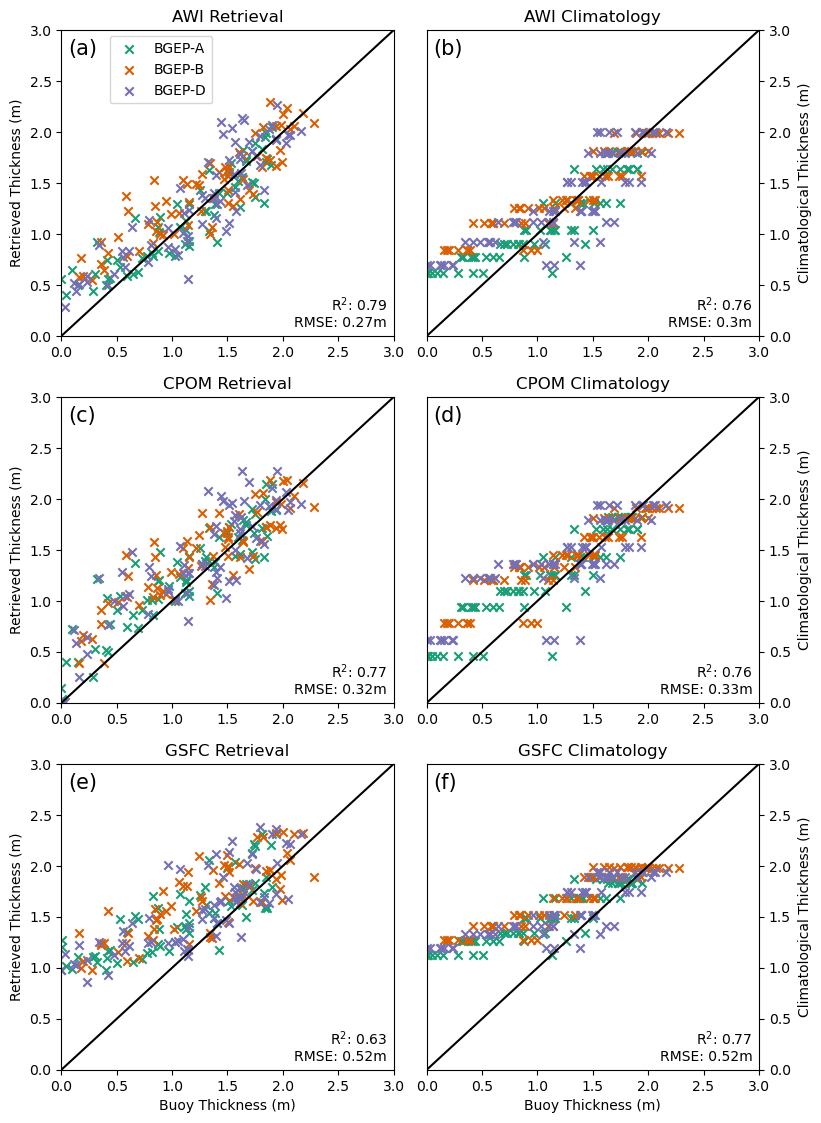

In [30]:
colors = {'a':'#1b9e77',
          'b':'#d95f02',
          'd':'#7570b3'}

fs = 10

for r in [100_000]:

    fig, axs = plt.subplots(3,2,figsize=(9,12*(9/8)))



    for var,label,(ax1,ax2) in zip([f'AWI_SIT_{r}',f'CPOM_SIT_{r}',f'NSIDC_SIT_{r}'],
                            ['AWI','CPOM','GSFC'],
                            axs):

        for buoy in ['a','b','d']:
            df = master_df[master_df['buoy']==buoy]

            ax1.scatter(df['SIT'],df[var],color=colors[buoy],label=f'BGEP-{buoy.upper()}',marker='x')

            ax2.scatter(df['SIT'],df[f'{var}_c'],color=colors[buoy],label=f'BGEP-{buoy.upper()}',marker='x')

        for ax, c in zip((ax1,ax2),['','_c']):
            ax.set_ylim(-0.1,3)
            ax.set_xlim(-0.1,3)
            ax.plot([0,3],[0,3],color='k')    

            if 'GSFC' == label:
                ax.set_xlabel('Buoy Thickness (m)',fontsize=10)


            df = master_df[['SIT',var+c,'month']].copy()

            df.dropna(inplace=True)

            rmse = np.sqrt(np.nanmean(np.square(df[var+c]-df['SIT'])))

            lr = linregress(df['SIT'],df[var+c])
            corr = lr[2]

            r2 = np.round(corr**2,decimals=2)
            rmse_str = np.round(rmse,decimals=2)

            ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                        xycoords='axes fraction',va='bottom',ha='right',fontsize=fs)



        ax1.set_ylabel('Retrieved Thickness (m)',fontsize=fs)
        ax2.set_ylabel('Climatological Thickness (m)',fontsize=fs,labelpad=5)

        ax1.set_title(f'{label} Retrieval',fontsize=fs+2)
        ax2.set_title(f'{label} Climatology',fontsize=fs+2)

        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position('right')
        
        for ax in (ax1,ax2):
            ax.set_xlim(0,3)
            ax.set_ylim(0,3)

    axs.reshape(-1)[0].legend(bbox_to_anchor=(0.3,0.87),loc='center',fontsize=fs)
    fig.subplots_adjust(hspace=0.2,wspace=0.1)
    
    for letter, ax in zip(string.ascii_lowercase, axs.reshape(-1)):
        ax.annotate(f'({letter})',xycoords='axes fraction',fontsize=fs+5,xy=(0.02,0.92))
    
    
    
    plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/Alpha Retracker/main_figs/climatology.png',bbox_inches='tight',dpi=500)
    
    plt.show()


10


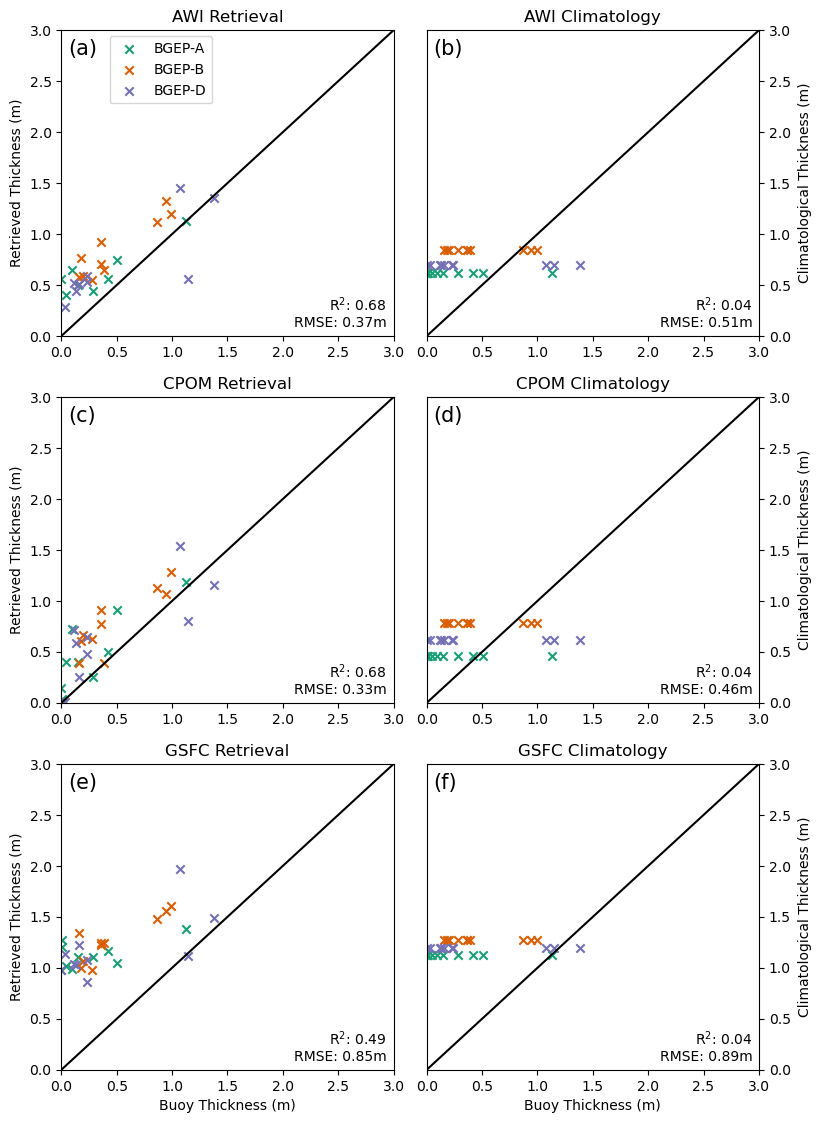


11


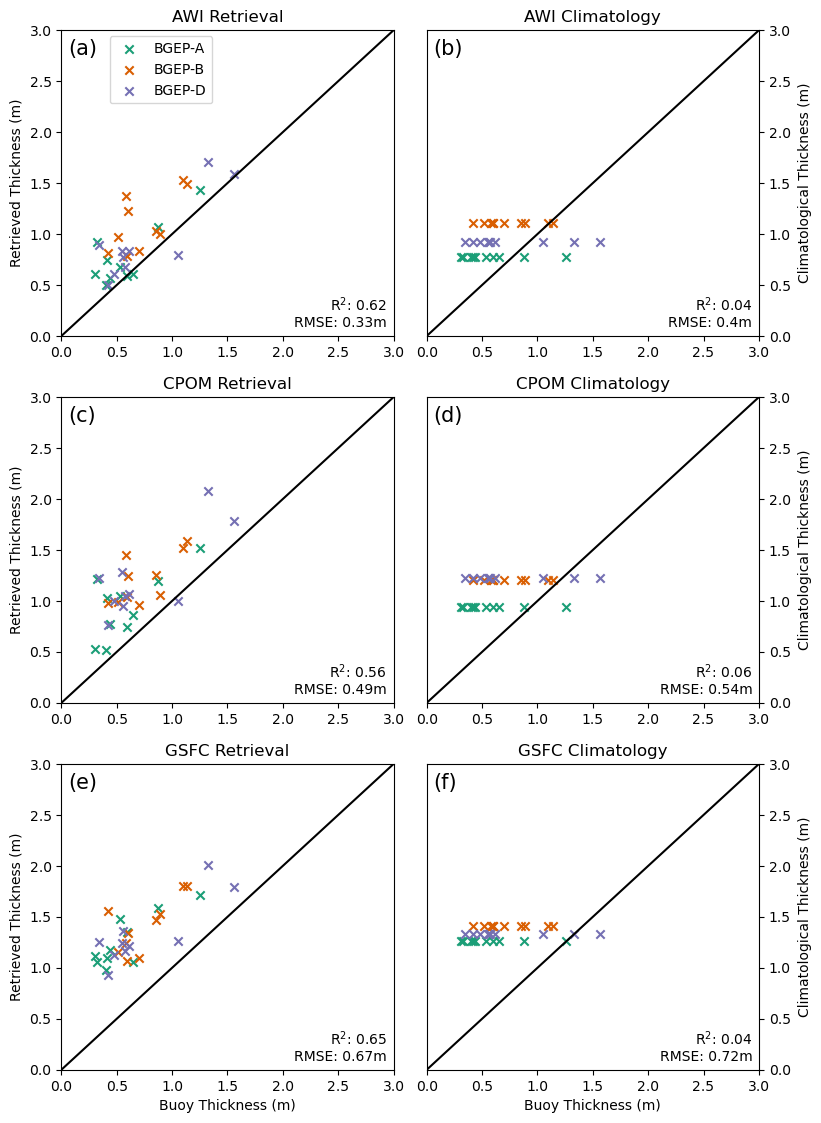


12


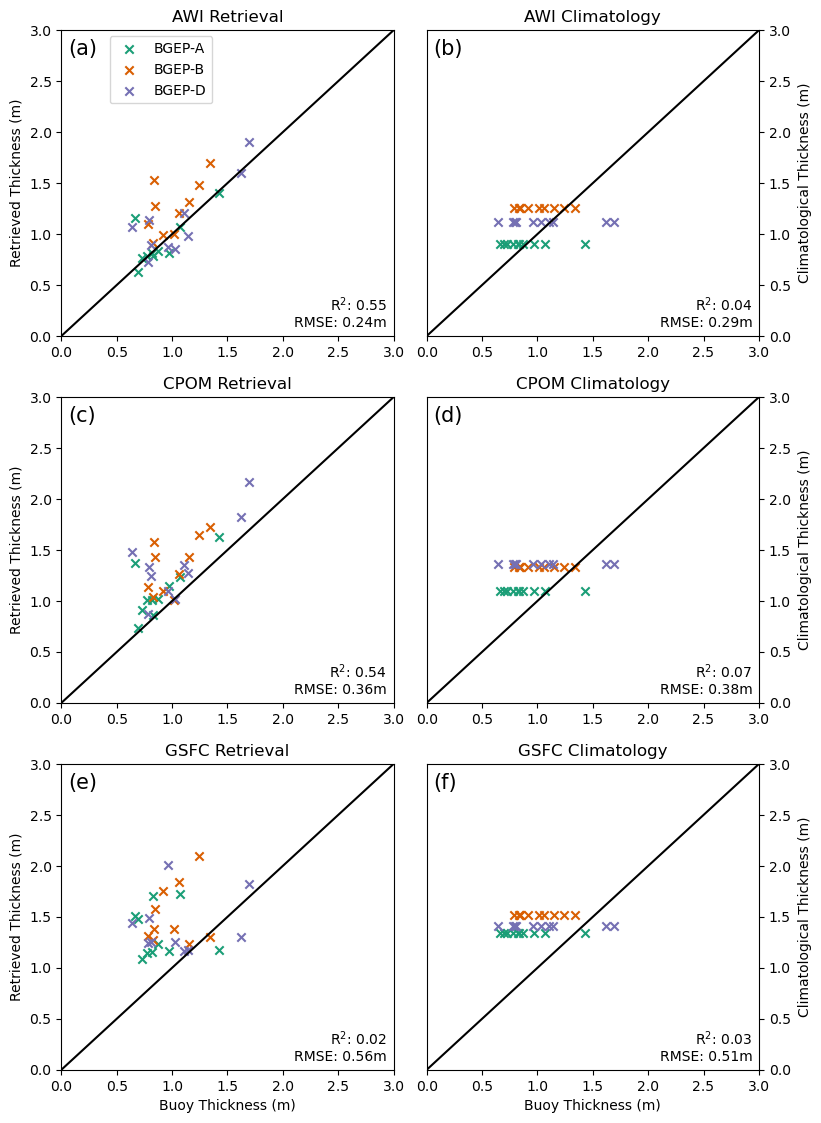


1


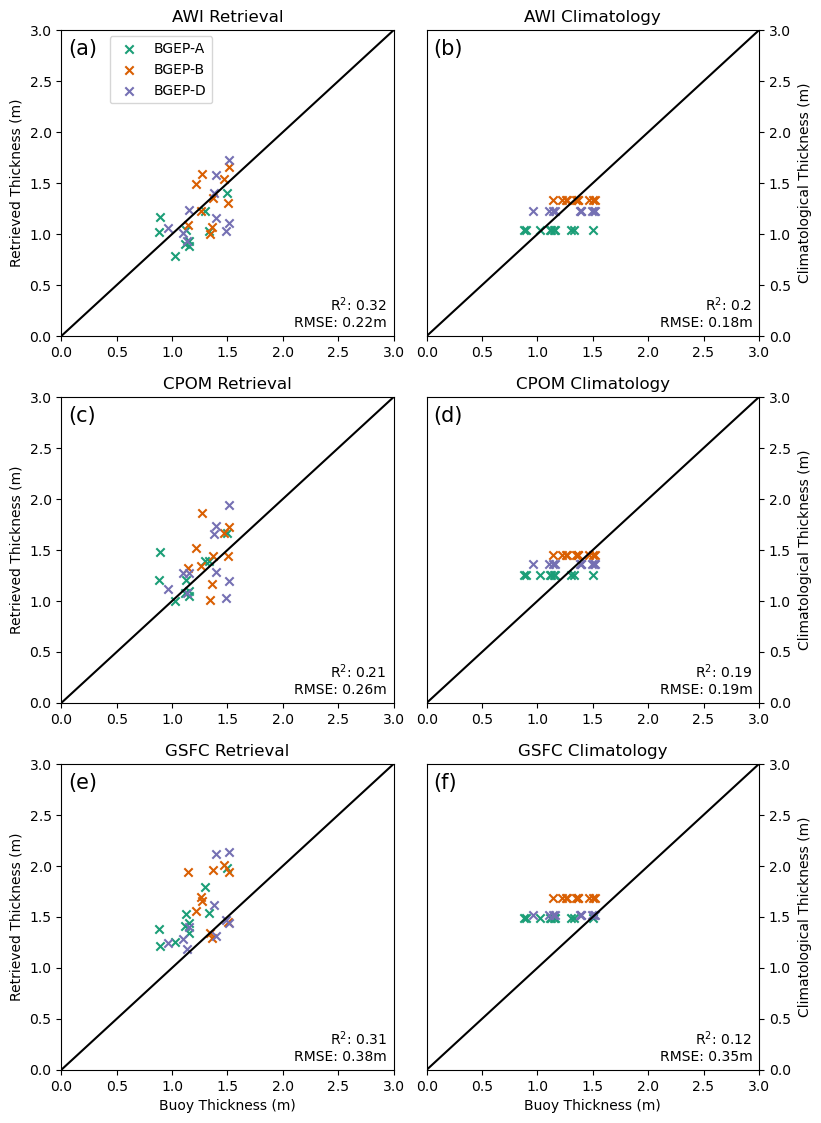


2


In [ ]:
output = {}

for m in [10,11,12,1,2,3,4]:
    
    print()
    print(m)
    
    
    m = str(m).zfill(2)

    output[m] = {}
    

    fs = 10


    for r in [100_000]:

        fig, axs = plt.subplots(3,2,figsize=(9,12*(9/8)))



        for var,label,(ax1,ax2) in zip([f'AWI_SIT_{r}',f'CPOM_SIT_{r}',f'NSIDC_SIT_{r}'],
                                ['AWI','CPOM','GSFC'],
                                axs):

            

            for buoy in ['a','b','d']:
                df = master_df[master_df['buoy']==buoy]

                df = df[df['month']==m]

                ax1.scatter(df['SIT'],df[var],color=colors[buoy],label=f'BGEP-{buoy.upper()}',marker='x')

                ax2.scatter(df['SIT'],df[f'{var}_c'],color=colors[buoy],label=f'BGEP-{buoy.upper()}',marker='x')

            for ax, c in zip((ax1,ax2),['','_c']):
                ax.set_ylim(-0.1,3)
                ax.set_xlim(-0.1,3)
                ax.plot([0,3],[0,3],color='k')    

                if 'GSFC' == label:
                    ax.set_xlabel('Buoy Thickness (m)',fontsize=10)


                df = master_df[['SIT',var+c,'month']].copy()

                df = df[df['month']==m]

                df.dropna(inplace=True)

                rmse = np.sqrt(np.nanmean(np.square(df[var+c]-df['SIT'])))

                lr = linregress(df['SIT'],df[var+c])
                corr = lr[2]

                r2 = np.round(corr**2,decimals=2)
                rmse_str = np.round(rmse,decimals=2)
                
                output[m][label+c] = f'{r2} / {rmse_str}'

                ax.annotate(f'R$^2$: {r2}\nRMSE: {rmse_str}m',xy=(0.98,0.02),
                            xycoords='axes fraction',va='bottom',ha='right',fontsize=fs)



            ax1.set_ylabel('Retrieved Thickness (m)',fontsize=fs)
            ax2.set_ylabel('Climatological Thickness (m)',fontsize=fs,labelpad=5)

            ax1.set_title(f'{label} Retrieval',fontsize=fs+2)
            ax2.set_title(f'{label} Climatology',fontsize=fs+2)

            ax2.yaxis.tick_right()
            ax2.yaxis.set_label_position('right')

            for ax in (ax1,ax2):
                ax.set_xlim(0,3)
                ax.set_ylim(0,3)

#         axs.reshape(-1)[0].legend(loc='upper left',fontsize=fs)
        axs.reshape(-1)[0].legend(bbox_to_anchor=(0.3,0.87),loc='center',fontsize=fs)

        fig.subplots_adjust(hspace=0.2,wspace=0.1)
        
        for letter, ax in zip(string.ascii_lowercase, axs.reshape(-1)):
            ax.annotate(f'({letter})',xycoords='axes fraction',fontsize=fs+5,xy=(0.02,0.92))
    
    

        plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/climatology_{m}.png',bbox_inches='tight',dpi=500)

        plt.show()

In [34]:
list_of_dicts = []

for month in output.keys():
    
    for product in output[month].keys():
    
        r2 = (output[month][product]['R2'])
        
        break
    
    break

0.68


In [40]:
df_ = pd.DataFrame(output).T

df_.to_csv('../data/skills.csv')